# Chapter 7 합성곱 신경망(CNN)

## 7.1 전체 구조
* Conv-ReLU-(Pooling) 구조의 반복

## 7.2 합성곱 계층
* padding, stride등의 CNN 고유의 용어 등장
* 3차원 데이터같이 입체적인 데이터가 흐름

### 7.2.1 완전연결 계층의 문제점
* 데이터의 형상이 무시됨. 1차원 데이터로 flatten해주기 때문
* 합성곱 계층은 형상을 유지하고, 이미지도 3차원 데이터로 받고 다음 계층에도 3차원 데이터로 전달함
* CNN에서는 합성곱 계층의 입출력 데이터를 **feature map**, 합성곱 계층의 입력 데이터를 **input feature map**, 출력 데이터를 **output feature map**이라고함
* 이 책에서는 입출력 데이터와 특징 맵을 같은 의미로 사용


### 7.2.2 합성곱 연산
* 합성곱 연산은 이미지 처리에서 말하는 **필터 연산**에 해당
* 문헌에 따라 필터를 커널이라 칭하기도함.(혼공머)
* 데이터와 필터의 형상을 (높이, 너비)로 표기
* 필터의 윈도우를 일정 간격으로 이동하며 입력 데이터에 적용
* 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구하고 편향을 더함

### 7.2.3 패딩
* 합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값으로 채우는 것
* 주로 출력의 크기를 조정할 목적으로 사용

### 7.2.4 스트라이드
* 필터를 적용하는 위치의 간격을 스트라이드(stride)라고 함

### 패딩, 스트라이드 출력 크기 계산
* 입력 크기: (H, W), 필터 크기: (FH, FW), 출력 크기: (OH, OW), 패딩: P, 스트라이트: S<br/><br/>
$ OH = \frac{H + 2P - FH}{S} + 1 $ <br/><br/>
$ OW = \frac{W + 2P - FW}{S} + 1 $ <br/><br/>
* 각각은 정수로 나눠떨어지는 값이어야 함


### 7.2.5 3차원 데이터의 합성곱 연산
* 입력 데이터의 채널 수와 필터의 채널 수가 같아야함
* 필터 자체의 크기는 원하는 값으로 설정가능

### 7.2.6 블록으로 생각하기
* 합성곱 연산의 출력으로 다수의 채널을 내보내려면 필터(가중치)를 다수 사용

### 7.2.7 배치 처리
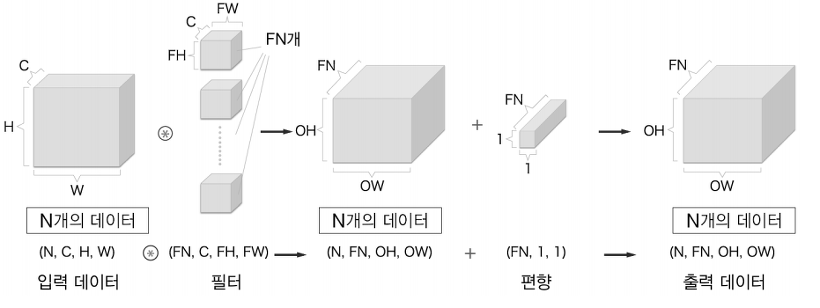

각 데이터의 선두에 배치용 차원을 추가. 신경망에 4차원 데이터가 하나 흐를  때마다 데이터 N개에 대한 합성곱 연산이 이루어짐. 즉, N회 분의 처리를 한 번에 수행

## 7.3 풀링 계층
* 세로·가로 방향의 공간을 줄이는 연산
* 일반적으로 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정
* 최대 풀링, 평균 풀링 등이 있음

### 7.3.1 풀링 계층의 특징
* 학습해야 할 매개변수가 없다
* 채널 수가 변하지 않는다
* 입력의 변화에 영향을 적게 받는다(강건하다)

## 7.4 합성곱/풀링 계층 구현하기

### 7.4.1 4차원 배열

In [8]:
import numpy as np

# 높이 28, 너비 28, 채널 1개인 데이터 10개
x = np.random.rand(10, 1, 28, 28)
print(x.shape)

# 첫 번째 데이터에 접근
print(x[0].shape)

print(x[1].shape)

# 첫 번째 데이터의 첫 채널의 공간 데이터
print(x[0, 0].shape)
print(x[0][0].shape)

(10, 1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(28, 28)
(28, 28)


### 7.4.2 im2col로 데이터 전개하기
* 넘파이에서는 원소에 접근할 때 for 문을 사용하지 않는 것이 바람직함
* im2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) 함수
* im2col을 사용해 구현하면 메모리를 더 많이 소비 But 컴퓨터는 큰 행렬을 묶어서 계산하는 데 탁월
* 따라서 문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용해 효율을 높일 수 있음

### 7.4.3 합성곱 계층 구현하기
* common/util.py에 im2col 구현 해놨음.

In [9]:
import sys, os
path = '/content/drive/MyDrive/DL_from_bottom'
os.chdir(path)
sys.path.append(os.chdir)
from common.util import im2col

# im2col(input_data, filter_h, filter_w, stride=1, pad=0)

x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)


(9, 75)
(90, 75)


In [10]:
# 합성곱 계층 구현
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


### 7.4.4 풀링 계층 구현하기

In [11]:
# 구현
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 최댓값 (2)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)

        # 성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


풀링 계층 구현<br/>
1. 입력 데이터를 전개
2. 행별 최댓값을 구한다
3. 적절한 모양으로 성형


## 7.5 CNN 구현하기
* Conv - ReLU - Pooling - Affine - ReLU - Affine - Softmax 

In [14]:
# 구현
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5,
                             'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        
        # 하이퍼파라미터를 딕셔너리에서 꺼내고 합성곱 계층의 출력 크기를 계산
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(fillter_num, input_dim[0],
                                            filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size,
                                            hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층 생성
        self.layers = {}
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(ppol_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'],
                                        self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],
                                        self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()

    # 예측
    def predict(self, x):
        for layer in self.values():
            x = layer.forward()
        return x

    # 손실
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    # 기울기
    def gradient(Self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads



In [ ]:
# SimpleConvNet 학습

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 7.6 CNN 시각화하기

### 7.6.1 1번째 층의 가중치 시각화하기
* 합성곱 계층의 필터는 에지나 블롭 등의 원시적인 정보를 추출할 수 있음

### 7.6.2 층 깊이에 따른 추출 정보 변화
* 계층이 깊어질수록 추출되는 정보는 더 추상화됨
* 즉, 층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 '고급'정보로 변화

## 7.7 대표적인 CNN

### 7.7.1 LeNet
* LeNet은 손글씨 숫자를 인식하는 네트워크
* 합성곱 계층과 풀링 계층을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력

### 7.7.2 AlexNet
* LeNet과의 차이점은 다음과 같다
>* 활성화 함수로 ReLU 이용
>* LRN이라는 국소적 정규화를 실시하는 계층을 이용
>* 드롭아웃 사용